# Snark (Snorkel on Spark) Tutorial

## Introduction

The central data-intensive operation in Snorkel is applying _labeling functions_ to unlabeled data. Snorkel then denoises the outputs of these labeling functions to infer a probabilistic label for each data point and train an end model.

We can accelerate the iterative process of developing labeling functions using Spark. The `SparkLabelAnnotator` distributes candidate sets (data points to be labeled) to a Spark cluster, then applies labeling functions and collects the results. We save time by distributing and caching the each candidate set once, then only transmitting labeling functions and collecting labels back in the Snorkel database.

This will demonstrate (one way) how to fit Spark into a Snorkel pipeline. This example can be inserted into many other applications.

## Installing `PySpark`

Please see the [official instructions](https://spark.apache.org/docs/latest/spark-standalone.html)!

## Setup
In this tutorial, we will continue with the chemical-disease relation extraction task from the [Chemical-Disease Tutorial](https://github.com/HazyResearch/snorkel/tree/master/tutorials/cdr). We will pick up here after the first notebook, the data preprocessing stage, so **remember to run [notebook 1](https://github.com/HazyResearch/snorkel/blob/master/tutorials/cdr/CDR_Tutorial_1.ipynb)** first, or un-zip the pre-run snorkel database from this preprocessing step:
```bash
cd tutorials/cdr
tar -xzvf tar -xzvf snorkel.CDR_1.db.tar.gz
mv snorkel.CDR_1.db snorkel.db
```

## Connecting Snorkel and Spark

We first create a `SnorkelSession` to load our data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# Remember to specify the SNORKELDB environment variable (with an absolute path if using the file system)
os.environ['SNORKELDB'] = 'sqlite:///' + os.getcwd() + os.sep + '../cdr/snorkel.db'

from snorkel import SnorkelSession

snorkel_session = SnorkelSession()

We also create a `SparkSession` to connect to a cluster.

In [3]:
from pyspark.sql import SparkSession

# Specify the URL to your Spark master node here
spark_session = SparkSession.builder.master("local").appName("Snark Tutorial").getOrCreate()

Finally, we specify the type of `Candidate` we will label. (This is initially defined in the [Chemical-Disease Tutorial](https://github.com/HazyResearch/snorkel/tree/master/tutorials/cdr).)

In [4]:
from snorkel.models import candidate_subclass

ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

for k in range(3):
    print("Number of candidates for split %d: %d" % (k, snorkel_session.query(ChemicalDisease).filter(ChemicalDisease.split == k).count()))

Number of candidates for split 0: 8272
Number of candidates for split 1: 888
Number of candidates for split 2: 4620


## Writing Labeling Functions

### Distant supervision approaches

We'll use the [Comparative Toxicogenomics Database](http://ctdbase.org/) (CTD) for distant supervision. The CTD lists chemical-condition entity pairs under three categories: therapy, marker, and unspecified. Therapy means the chemical treats the condition, marker means the chemical is typically present with the condition, and unspecified is... unspecified. We can write LFs based on these categories.

Note that we'll load the database as in the [Chemical-Disease Tutorial](https://github.com/HazyResearch/snorkel/tree/master/tutorials/cdr), but now that we're using Spark, we'll also _broadcast_ it to our workers. This allows the distributed labeling functions to use the data.

In [5]:
import bz2
import cPickle

with bz2.BZ2File('../cdr/data/ctd.pkl.bz2', 'rb') as ctd_f:
    ctd_unspecified, ctd_therapy, ctd_marker = cPickle.load(ctd_f)

ctd_unspecified = spark_session.sparkContext.broadcast(ctd_unspecified)
ctd_therapy = spark_session.sparkContext.broadcast(ctd_therapy)
ctd_marker = spark_session.sparkContext.broadcast(ctd_marker)

(We define these primitive membership checks for later reuse.)

In [6]:
def cand_in_ctd_unspecified(c):
    return 1 if c.get_cids() in ctd_unspecified.value else 0

def cand_in_ctd_therapy(c):
    return 1 if c.get_cids() in ctd_therapy.value else 0

def cand_in_ctd_marker(c):
    return 1 if c.get_cids() in ctd_marker.value else 0

Distant supervision labeling functions:

In [7]:
def LF_in_ctd_unspecified(c):
    return -1 * cand_in_ctd_unspecified(c)

def LF_in_ctd_therapy(c):
    return -1 * cand_in_ctd_therapy(c)

def LF_in_ctd_marker(c):
    return cand_in_ctd_marker(c)

### Text pattern approaches

Now we'll use some LF helpers to create LFs based on indicative text patterns. We came up with these rules by using the viewer to examine training candidates and noting frequent patterns.

In [8]:
import re
from snorkel.lf_helpers import (
    get_tagged_text,
    rule_regex_search_tagged_text,
    rule_regex_search_btw_AB,
    rule_regex_search_btw_BA,
    rule_regex_search_before_A,
    rule_regex_search_before_B,
)

# List to parenthetical
def ltp(x):
    return '(' + '|'.join(x) + ')'

def LF_induce(c):
    return 1 if re.search(r'{{A}}.{0,20}induc.{0,20}{{B}}', get_tagged_text(c), flags=re.I) else 0

causal_past = ['induced', 'caused', 'due']
def LF_d_induced_by_c(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + '.{0,9}(by|to).{0,50}', 1)
def LF_d_induced_by_c_tight(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(causal_past) + ' (by|to) ', 1)

def LF_induce_name(c):
    return 1 if 'induc' in c.chemical.get_span().lower() else 0     

causal = ['cause[sd]?', 'induce[sd]?', 'associated with']
def LF_c_cause_d(c):
    return 1 if (
        re.search(r'{{A}}.{0,50} ' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
        and not re.search('{{A}}.{0,50}(not|no).{0,20}' + ltp(causal) + '.{0,50}{{B}}', get_tagged_text(c), re.I)
    ) else 0

treat = ['treat', 'effective', 'prevent', 'resistant', 'slow', 'promise', 'therap']
def LF_d_treat_c(c):
    return rule_regex_search_btw_BA(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)
def LF_c_treat_d(c):
    return rule_regex_search_btw_AB(c, '.{0,50}' + ltp(treat) + '.{0,50}', -1)
def LF_treat_d(c):
    return rule_regex_search_before_B(c, ltp(treat) + '.{0,50}', -1)
def LF_c_treat_d_wide(c):
    return rule_regex_search_btw_AB(c, '.{0,200}' + ltp(treat) + '.{0,200}', -1)

def LF_c_d(c):
    return 1 if ('{{A}} {{B}}' in get_tagged_text(c)) else 0

def LF_c_induced_d(c):
    return 1 if (
        ('{{A}} {{B}}' in get_tagged_text(c)) and 
        (('-induc' in c[0].get_span().lower()) or ('-assoc' in c[0].get_span().lower()))
        ) else 0

def LF_improve_before_disease(c):
    return rule_regex_search_before_B(c, 'improv.*', -1)

pat_terms = ['in a patient with ', 'in patients with']
def LF_in_patient_with(c):
    return -1 if re.search(ltp(pat_terms) + '{{B}}', get_tagged_text(c), flags=re.I) else 0

uncertain = ['combin', 'possible', 'unlikely']
def LF_uncertain(c):
    return rule_regex_search_before_A(c, ltp(uncertain) + '.*', -1)

def LF_induced_other(c):
    return rule_regex_search_tagged_text(c, '{{A}}.{20,1000}-induced {{B}}', -1)

def LF_far_c_d(c):
    return rule_regex_search_btw_AB(c, '.{100,5000}', -1)

def LF_far_d_c(c):
    return rule_regex_search_btw_BA(c, '.{100,5000}', -1)

def LF_risk_d(c):
    return rule_regex_search_before_B(c, 'risk of ', 1)

def LF_develop_d_following_c(c):
    return 1 if re.search(r'develop.{0,25}{{B}}.{0,25}following.{0,25}{{A}}', get_tagged_text(c), flags=re.I) else 0

procedure, following = ['inject', 'administrat'], ['following']
def LF_d_following_c(c):
    return 1 if re.search('{{B}}.{0,50}' + ltp(following) + '.{0,20}{{A}}.{0,50}' + ltp(procedure), get_tagged_text(c), flags=re.I) else 0

def LF_measure(c):
    return -1 if re.search('measur.{0,75}{{A}}', get_tagged_text(c), flags=re.I) else 0

def LF_level(c):
    return -1 if re.search('{{A}}.{0,25} level', get_tagged_text(c), flags=re.I) else 0

def LF_neg_d(c):
    return -1 if re.search('(none|not|no) .{0,25}{{B}}', get_tagged_text(c), flags=re.I) else 0

WEAK_PHRASES = ['none', 'although', 'was carried out', 'was conducted',
                'seems', 'suggests', 'risk', 'implicated',
               'the aim', 'to (investigate|assess|study)']

WEAK_RGX = r'|'.join(WEAK_PHRASES)

def LF_weak_assertions(c):
    return -1 if re.search(WEAK_RGX, get_tagged_text(c), flags=re.I) else 0

### Composite LFs

The following LFs take some of the strongest distant supervision and text pattern LFs, and combine them to form more specific LFs. These LFs introduce some obvious dependencies within the LF set, which we will model later.

In [9]:
def LF_ctd_marker_c_d(c):
    return LF_c_d(c) * cand_in_ctd_marker(c)

def LF_ctd_marker_induce(c):
    return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_marker(c)

def LF_ctd_therapy_treat(c):
    return LF_c_treat_d_wide(c) * cand_in_ctd_therapy(c)

def LF_ctd_unspecified_treat(c):
    return LF_c_treat_d_wide(c) * cand_in_ctd_unspecified(c)

def LF_ctd_unspecified_induce(c):
    return (LF_c_induced_d(c) or LF_d_induced_by_c_tight(c)) * cand_in_ctd_unspecified(c)

### Rules based on context hierarchy

These last two rules will make use of the context hierarchy. The first checks if there is a chemical mention much closer to the candidate's disease mention than the candidate's chemical mention. The second does the analog for diseases.

In [10]:
def LF_closer_chem(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical closer than @dist/2 in either direction
    sent = c.get_parent()
    closest_other_chem = float('inf')
    for i in range(dis_end, min(len(sent.words), dis_end + dist / 2)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    for i in range(max(0, dis_start - dist / 2), dis_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Chemical' and cid != sent.entity_cids[chem_start]:
            return -1
    return 0

def LF_closer_dis(c):
    # Get distance between chemical and disease
    chem_start, chem_end = c.chemical.get_word_start(), c.chemical.get_word_end()
    dis_start, dis_end = c.disease.get_word_start(), c.disease.get_word_end()
    if dis_start < chem_start:
        dist = chem_start - dis_end
    else:
        dist = dis_start - chem_end
    # Try to find chemical disease than @dist/8 in either direction
    sent = c.get_parent()
    for i in range(chem_end, min(len(sent.words), chem_end + dist / 8)):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return -1
    for i in range(max(0, chem_start - dist / 8), chem_start):
        et, cid = sent.entity_types[i], sent.entity_cids[i]
        if et == 'Disease' and cid != sent.entity_cids[dis_start]:
            return -1
    return 0

Collects all LFs in a list:

In [11]:
DS = [LF_in_ctd_therapy, LF_in_ctd_marker, LF_in_ctd_unspecified]
LFs = [
    LF_c_cause_d, LF_c_d, LF_c_induced_d, LF_c_treat_d, LF_c_treat_d_wide,
    LF_closer_chem, LF_closer_dis, LF_ctd_marker_c_d, LF_ctd_marker_induce,
    LF_ctd_therapy_treat, LF_ctd_unspecified_treat, LF_ctd_unspecified_induce, LF_d_following_c,
    LF_d_induced_by_c, LF_d_induced_by_c_tight, LF_d_treat_c, LF_develop_d_following_c, LF_far_c_d,
    LF_far_d_c, LF_improve_before_disease, 
    LF_in_patient_with, LF_induce, LF_induce_name, LF_induced_other,
    LF_level, LF_measure, LF_neg_d, LF_risk_d,
    LF_treat_d, LF_uncertain, LF_weak_assertions,
]

## Executing Labeling Functions on Spark

Finally, we create a `SparkLabelAnnotator` to distribute the data, execute the labeling functions, and collect the results back into the local Snorkel database.

In [12]:
from snorkel.contrib.snark import SparkLabelAnnotator

annotator = SparkLabelAnnotator(snorkel_session, spark_session, ChemicalDisease)

In [13]:
%time L_train = annotator.apply(DS + LFs, split=0)

Applying labelling functions to 8272 candidates
CPU times: user 5.45 s, sys: 156 ms, total: 5.61 s
Wall time: 1min 31s


In [14]:
L_train.lf_stats(snorkel_session)

,j,Coverage,Overlaps,Conflicts
LF_in_ctd_therapy,0,0.296905,0.285058,0.174565
LF_in_ctd_marker,1,0.610977,0.553796,0.525145
LF_in_ctd_unspecified,2,0.666707,0.626572,0.475218
LF_c_cause_d,3,0.032519,0.030222,0.024782
LF_c_d,4,0.092602,0.089821,0.074347
LF_c_induced_d,5,0.070358,0.070358,0.058027
LF_c_treat_d,6,0.045938,0.045938,0.019221
LF_c_treat_d_wide,7,0.086315,0.085469,0.037476
LF_closer_chem,8,0.193303,0.183873,0.099613
LF_closer_dis,9,0.018133,0.017529,0.012935


## Training the Generative Model

Now that the labeling functions have been executed, you can resume the chemical-disease task at Part IV in [notebook 2](https://github.com/HazyResearch/snorkel/blob/master/tutorials/cdr/CDR_Tutorial_2.ipynb)!

This general approach to distributing labeling function execution can be integrated into many different Snorkel applications.

In [15]:
from snorkel.learning.structure import DependencySelector
ds = DependencySelector()
deps = ds.select(L_train, threshold=0.1)
len(deps)

219

In [16]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel(lf_propensity=True)
gen_model.train(
    L_train, deps=deps, decay=0.95, step_size=0.1/L_train.shape[0], reg_param=0.0
)

Inferred cardinality: 2


In [17]:
train_marginals = gen_model.marginals(L_train)

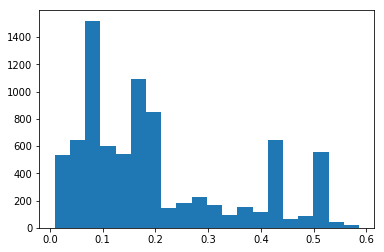

In [18]:
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [19]:
gen_model.learned_lf_stats()

,Accuracy,Coverage,Precision,Recall
0,0.730867,0.1568,0.761780,0.116493
1,0.396909,0.6470,0.401060,0.257606
2,0.819227,0.6782,0.817421,0.567254
3,0.519231,0.0052,0.468750,0.003002
4,0.530075,0.0266,0.514925,0.013811
5,0.548673,0.0226,0.560000,0.011209
6,0.562500,0.0032,0.600000,0.002402
7,0.611354,0.0229,0.627119,0.014812
8,0.673010,0.1156,0.672535,0.076461
9,0.357143,0.0014,0.300000,0.000600


In [20]:
from snorkel.annotations import save_marginals
save_marginals(snorkel_session, L_train, train_marginals)

Saved 8272 marginals


### Checking performance against development set labels

Finally, we'll run the labeler on the development set, load in some external labels, then evaluate the LF performance. The external labels are applied via a small script for convenience. It maps the document-level relation annotations found in the CDR file to mention-level labels. Note that these will not be perfect, although they are pretty good. If we wanted to keep iterating, we could use `snorkel.lf_helpers.test_LF` against the dev set, or look at some false positive and false negative candidates.

In [21]:
from load_external_annotations import load_external_labels
load_external_labels(snorkel_session, ChemicalDisease, split=1, annotator='gold')

AnnotatorLabels created: 0


In [22]:
from snorkel.annotations import load_gold_labels
L_gold_dev = load_gold_labels(snorkel_session, annotator_name='gold', split=1)
L_gold_dev

<888x1 sparse matrix of type '<type 'numpy.int64'>'
	with 888 stored elements in Compressed Sparse Row format>

In [23]:
L_dev = annotator.apply(DS, split=1)

Py4JJavaError: An error occurred while calling o334.load.
: java.sql.SQLException: [SQLITE_BUSY]  The database file is locked (database is locked)
	at org.sqlite.core.DB.newSQLException(DB.java:890)
	at org.sqlite.core.DB.newSQLException(DB.java:901)
	at org.sqlite.core.DB.throwex(DB.java:868)
	at org.sqlite.core.NativeDB.prepare(Native Method)
	at org.sqlite.core.DB.prepare(DB.java:211)
	at org.sqlite.core.CorePreparedStatement.<init>(CorePreparedStatement.java:40)
	at org.sqlite.jdbc3.JDBC3PreparedStatement.<init>(JDBC3PreparedStatement.java:29)
	at org.sqlite.jdbc4.JDBC4PreparedStatement.<init>(JDBC4PreparedStatement.java:18)
	at org.sqlite.jdbc4.JDBC4Connection.prepareStatement(JDBC4Connection.java:47)
	at org.sqlite.jdbc3.JDBC3Connection.prepareStatement(JDBC3Connection.java:251)
	at org.sqlite.jdbc3.JDBC3Connection.prepareStatement(JDBC3Connection.java:223)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCRDD$.resolveTable(JDBCRDD.scala:60)
	at org.apache.spark.sql.execution.datasources.jdbc.JDBCRelation.<init>(JDBCRelation.scala:113)
	at org.apache.spark.sql.execution.datasources.jdbc.JdbcRelationProvider.createRelation(JdbcRelationProvider.scala:47)
	at org.apache.spark.sql.execution.datasources.DataSource.resolveRelation(DataSource.scala:306)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:178)
	at org.apache.spark.sql.DataFrameReader.load(DataFrameReader.scala:146)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:748)


In [ ]:
_ = gen_model.error_analysis(snorkel_session, L_dev, L_gold_dev)

In [ ]:
L_dev.lf_stats(snorkel_session, L_gold_dev, gen_model.learned_lf_stats()['Accuracy'])

# Computing features

For `SparseLogReg`

In [ ]:
from snorkel.annotations import FeatureAnnotator
featurizer = SparkFeatureAnnotator(
    snorkel_session, spark_session, ChemicalDisease, split_cache=annotator.split_cache)

%time F_train = featurizer.apply(split=0)
F_train

In [ ]:
%%time
F_dev  = featurizer.apply(split=1)
F_test = featurizer.apply(split=2)

# Training `SparseLogReg`

Instead of LSTM, to start.  First, reloading training marginals: